<a href="https://colab.research.google.com/github/o-souter/AdvancedAICW/blob/main/AdvancedAICW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CMM307 Coursework

# Section 1: Dataset Exploration and Preprocessing

This coursework will use Kwaai's variant of the IMDB review dataset, found on huggingface in the link below. The main aim of this coursework is to explore and preprocess this data, before using it to test the effectiveness of a SVM and RNN algorithm in Sentiment analysis of IMDB reviews.

In addition, this coursework will go over the below paper, exploring ULMFiT in its ability to recognise sentiment and determine whether or not a given review is positive or negative.

Dataset: https://huggingface.co/datasets/Kwaai/IMDB_Sentiment

ULMFiT paper: https://paperswithcode.com/paper/universal-language-model-fine-tuning-for-text

In [59]:
#The below code loads the dataset. For this to work, you will need to set up an Access token in huggingface.
#Then it should be added to google colab using the left sidebar 'Secrets' section, with the name of 'HF_TOKEN' and value the token's value.

import pandas as pd
from google.colab import userdata
userdata.get('HF_TOKEN')

splits = {'train': 'plain_text/train-00000-of-00001.parquet', 'test': 'plain_text/test-00000-of-00001.parquet', 'unsupervised': 'plain_text/unsupervised-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/Kwaai/IMDB_Sentiment/" + splits["train"])

print(df)

del splits #Clean up as no longer needed


                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          text  \
0      I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish d

Once loaded in, we can visualise the dataset's class distrubution, confirming a balanced dataset that avoids bias.

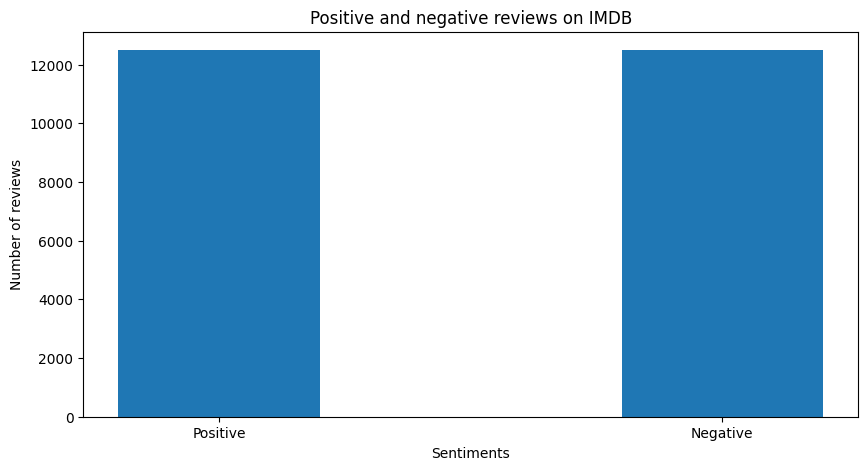

In [60]:
import numpy as np
import matplotlib.pyplot as plt

sentiments = ["Positive", "Negative"]
positiveSentiments = len(df[df['label'] == 1])
negativeSentiments = len(df[df['label'] == 0])

fig = plt.figure(figsize = (10, 5))
types = ["Positive", "Negative"]
values = [positiveSentiments, negativeSentiments]
plt.bar(types, values, width = 0.4)

plt.xlabel("Sentiments")
plt.ylabel("Number of reviews")
plt.title("Positive and negative reviews on IMDB")

plt.show()

Measuring word frequency can help us to determine which words may be used more commonly to describe a positive or negative review. It will also help us to find words that might cause issues due to high frequency across both types of review.

In [61]:
# This will need to be run before the below graphs can be generated!!

#Get the top X words by setting this variable - used in bar graphs below
count = 20
# Split to positive and negative sentiments in reviews, for word cloud and graph
positiveSentiments = df[df['label'] == 1]
negativeSentiments = df[df['label'] == 0]
# print(positiveSentiments['text'])
allPositiveWords = ' '.join(positiveSentiments['text']).split()
allNegativeWords = ' '.join(negativeSentiments['text']).split()

#Sort by word frequency
mostCommonPositiveWords = pd.Series(allPositiveWords).value_counts()
mostCommonNegativeWords = pd.Series(allPositiveWords).value_counts()

In [ ]:
#Install if required
!pip install wordcloud

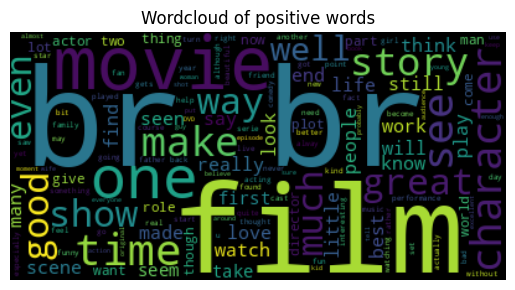

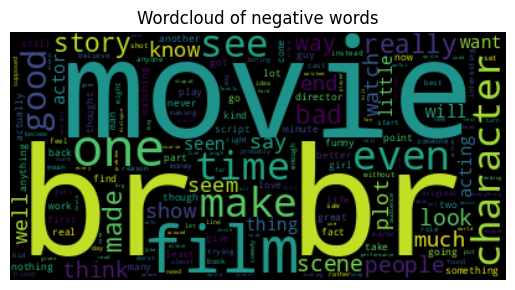

In [62]:
#Create word clouds to show most common words
from wordcloud import WordCloud
import matplotlib.pyplot as plt

positiveWordCloud = WordCloud().generate(' '.join(allPositiveWords))
negativeWordCloud = WordCloud().generate(' '.join(allNegativeWords))
plt.imshow(positiveWordCloud, interpolation='bilinear')
plt.title("Wordcloud of positive words")
plt.axis("off")
plt.show()

plt.imshow(negativeWordCloud, interpolation='bilinear')
plt.title("Wordcloud of negative words")
plt.axis("off")
plt.show()

From the two wordclouds, it is shown that 'film' and 'movie' are both very common words used across positive and negative reviews. Since these words are not descriptive of whether or not a review is positive or negative, as they will all likely mention a movie or film at some point, these words should be removed later.

In addition, another common word shown here, is 'br'. However this is not actually a word, and is instead a piece of HTML used to separate pages and text. This should also be removed later as it is not relevant.

A more measured metric is to show the top 20 most popular words in the dataset for positive and negative reviews, as shown in the below graph generated.

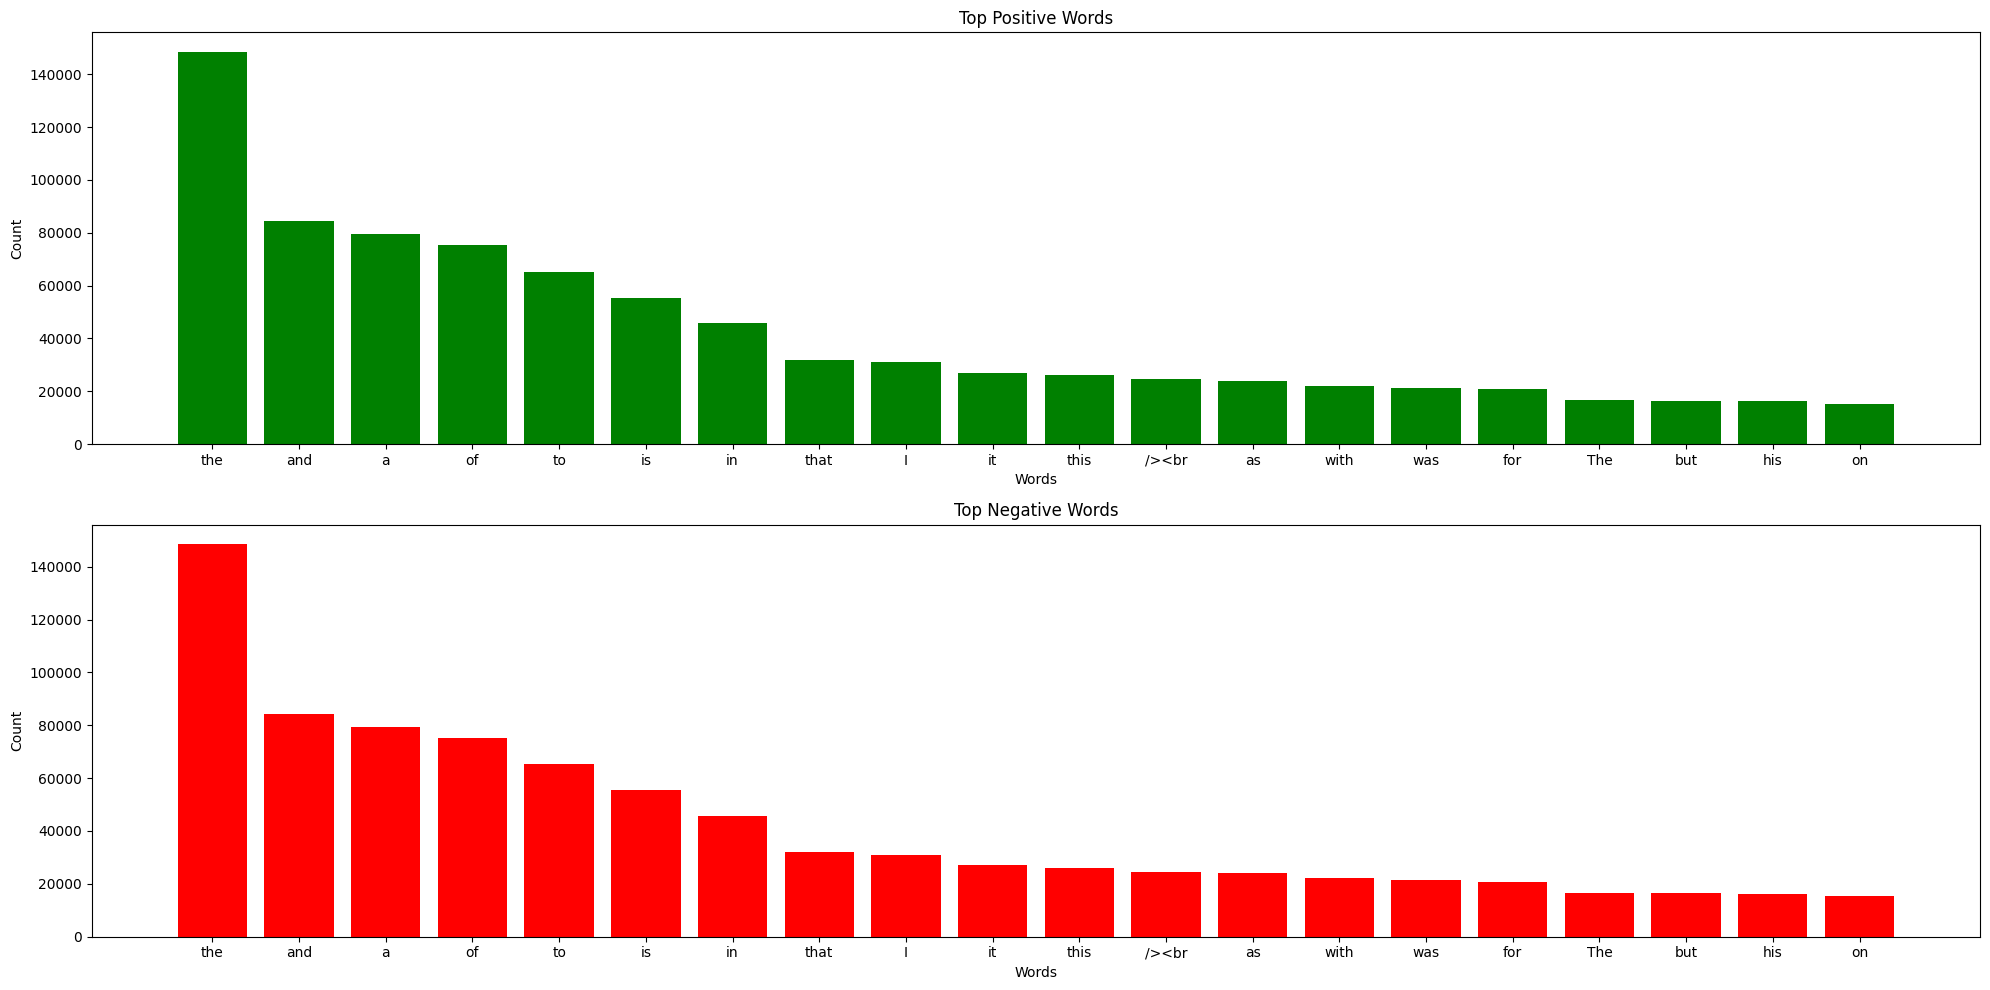

<Figure size 1000x600 with 0 Axes>

In [64]:
#Get top X most common words as dicts
topXPositiveWordsDict = mostCommonPositiveWords[0:count].to_dict()
topXNegativeWordsDict = mostCommonNegativeWords[0:count].to_dict()

#Get the keys to have just the words

topPositiveWords = topXPositiveWordsDict.keys()
topNegativeWords = topXNegativeWordsDict.keys()

#Get the counts to show in graphs

topPositiveWordsCount = topXPositiveWordsDict.values()
topNegativeWordsCount = topXNegativeWordsDict.values()

#Create graphs and subplot
#Adjust fig size to number of words in each graph
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (count,10))

#Plot positive word graph
axes[0].bar(topPositiveWords, topPositiveWordsCount, color='green')
axes[0].set_title('Top Positive Words')
axes[0].set_xlabel('Words')
axes[0].set_ylabel('Count')

#Plot negative word graph
axes[1].bar(topNegativeWords, topNegativeWordsCount, color='red')
axes[1].set_title('Top Negative Words')
axes[1].set_xlabel('Words')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.figure(figsize=(10,6))
plt.show()

As the above graphs show, the dataset is dominated by meaningless words such as 'the', 'and', 'a', 'of' etc. Since these words hold no sentiment, their frequency could trick an algorithm into thinking that they have more meaning than they actually do. This is handled in stop word removal during preprocessing.

The first step of Preprocessing is Tokenization, where each movie review starts off as a string, and is converted to a list of words.

In [65]:
def tokenize_texts(input): #Tokenizing function
  output = []
  for text in input:
    newText = text.split(" ") #Split each review into a list of every word, using space to determine where to take the splits
    output.append(newText)

  return pd.Series(output) #Convert to a series to be inserted back into the dataframe without issues

#We make a copy of the original dataframe before running the tokenization, so that we can compare the before and after.
tokenized_df = df.copy(deep=True)
tokenized_df['text'] = tokenize_texts(tokenized_df['text'])
print(df['text'][0])
print(tokenized_df['text'][0])



I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, eve

The next step of preprocessing is Normalisation. In the below code, this involves:
*   Converting every character in each review into lowercase - this avoids confusion between words that might be cased differently but mean the same thing, e.g. "Bad" and "bad"
*   Removing the HTML '\<br>' tags as found above in the word clouds - these have no relevance or meaning to the sentiment of each review.
*   Removing any characters that are not alphabetical - it's likely that numerical data or symbols will not be useful, or will be difficult for an algorithm to understand to show sentiment, so these are removed.



In [66]:
import re
def normalise_texts(input):
  output = []
  for text in input:
    text = [word.lower() for word in text] #Convert all words to lowercase

    text = [word.replace('<br', '').replace('/><br', '') for word in text] #Remove all page break code which can cause malformed words

    text = [re.sub(r'[^a-zA-Z]', '', word) for word in text] #Remove any characters that are not a-z, using regex

    output.append(text)
  return pd.Series(output)

#We make a copy of the original dataframe before running the tokenization, so that we can compare the before and after.
normalised_df = tokenized_df.copy(deep=True)
normalised_df['text'] = normalise_texts(normalised_df['text'])
print(tokenized_df['text'][0])
print(normalised_df['text'][0])

del tokenized_df #Clean up as we no longer need the previous dataframe

['I', 'rented', 'I', 'AM', 'CURIOUS-YELLOW', 'from', 'my', 'video', 'store', 'because', 'of', 'all', 'the', 'controversy', 'that', 'surrounded', 'it', 'when', 'it', 'was', 'first', 'released', 'in', '1967.', 'I', 'also', 'heard', 'that', 'at', 'first', 'it', 'was', 'seized', 'by', 'U.S.', 'customs', 'if', 'it', 'ever', 'tried', 'to', 'enter', 'this', 'country,', 'therefore', 'being', 'a', 'fan', 'of', 'films', 'considered', '"controversial"', 'I', 'really', 'had', 'to', 'see', 'this', 'for', 'myself.<br', '/><br', '/>The', 'plot', 'is', 'centered', 'around', 'a', 'young', 'Swedish', 'drama', 'student', 'named', 'Lena', 'who', 'wants', 'to', 'learn', 'everything', 'she', 'can', 'about', 'life.', 'In', 'particular', 'she', 'wants', 'to', 'focus', 'her', 'attentions', 'to', 'making', 'some', 'sort', 'of', 'documentary', 'on', 'what', 'the', 'average', 'Swede', 'thought', 'about', 'certain', 'political', 'issues', 'such', 'as', 'the', 'Vietnam', 'War', 'and', 'race', 'issues', 'in', 'the',

Stop word removal is a major step in preprocessing, involving removing words that have no meaning to an algorithm, to help refine input down into the most important words. In this case, we use nltk's list of stop words, which contains the most common stop words. In addition, we use our own custom list, containing "film", "films", "movie" and "movies". Since "film" and "movie" were found to be extremely common words across both positive and negative reviews, it's likely that these words (and their plurals) will not be useful to help an algorithm determine sentiment, especially since you would expect to see these words in any typical review.

In [67]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
# print(stopwords.words('english'))
stop_words = set(stopwords.words('english'))
my_stop_words = set(['film', 'films', 'movie', 'movies'])
def remove_stop_words_from_text(input):
  output = []
  for text in input:
    text = [word for word in text if not (word in stop_words or word in my_stop_words)]
    output.append(text)
  return pd.Series(output)

stop_word_removed_text = normalised_df.copy(deep=True)
stop_word_removed_text['text'] = remove_stop_words_from_text(stop_word_removed_text['text'])
print(normalised_df['text'][0])
print(stop_word_removed_text['text'][0])

del normalised_df #Clean up as we no longer need the previous dataframe

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i', 'rented', 'i', 'am', 'curiousyellow', 'from', 'my', 'video', 'store', 'because', 'of', 'all', 'the', 'controversy', 'that', 'surrounded', 'it', 'when', 'it', 'was', 'first', 'released', 'in', '', 'i', 'also', 'heard', 'that', 'at', 'first', 'it', 'was', 'seized', 'by', 'us', 'customs', 'if', 'it', 'ever', 'tried', 'to', 'enter', 'this', 'country', 'therefore', 'being', 'a', 'fan', 'of', 'films', 'considered', 'controversial', 'i', 'really', 'had', 'to', 'see', 'this', 'for', 'myself', '', 'the', 'plot', 'is', 'centered', 'around', 'a', 'young', 'swedish', 'drama', 'student', 'named', 'lena', 'who', 'wants', 'to', 'learn', 'everything', 'she', 'can', 'about', 'life', 'in', 'particular', 'she', 'wants', 'to', 'focus', 'her', 'attentions', 'to', 'making', 'some', 'sort', 'of', 'documentary', 'on', 'what', 'the', 'average', 'swede', 'thought', 'about', 'certain', 'political', 'issues', 'such', 'as', 'the', 'vietnam', 'war', 'and', 'race', 'issues', 'in', 'the', 'united', 'states', 'i

Now that irrelevant and problematic words and characters have been removed, we revisualize the data as before, to show which words might have positive or negative sentiment.

In [69]:
# This will need to be run before the below graphs can be generated!!

#Get the top X words by setting this variable
count = 20
# Split to positive and negative sentiments in reviews

#Copy as we will need to change the df again to visualise
visualised_df = stop_word_removed_text.copy(deep=True)

positiveSentiments = visualised_df[visualised_df['label'] == 1].copy()
negativeSentiments = visualised_df[visualised_df['label'] == 0].copy()

positiveSentiments['text'] = [' '.join(text) for text in positiveSentiments['text']]
negativeSentiments['text'] = [' '.join(text) for text in negativeSentiments['text']]

# print(positiveSentiments['text'])

allPositiveWords = (' '.join(positiveSentiments['text'])).split()
allNegativeWords = (' '.join(negativeSentiments['text'])).split()

#Sort by most common words
mostCommonPositiveWords = pd.Series(allPositiveWords).value_counts()
mostCommonNegativeWords = pd.Series(allNegativeWords).value_counts()

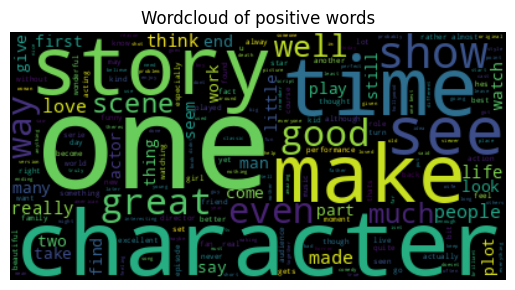

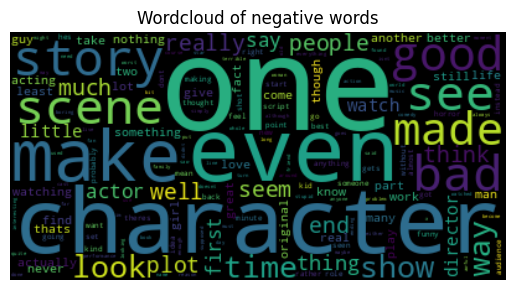

In [37]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

positiveWordCloud = WordCloud().generate(' '.join(allPositiveWords))
negativeWordCloud = WordCloud().generate(' '.join(allNegativeWords))
plt.imshow(positiveWordCloud, interpolation='bilinear')
plt.title("Wordcloud of positive words")
plt.axis("off")
plt.show()

plt.imshow(negativeWordCloud, interpolation='bilinear')
plt.title("Wordcloud of negative words")
plt.axis("off")
plt.show()

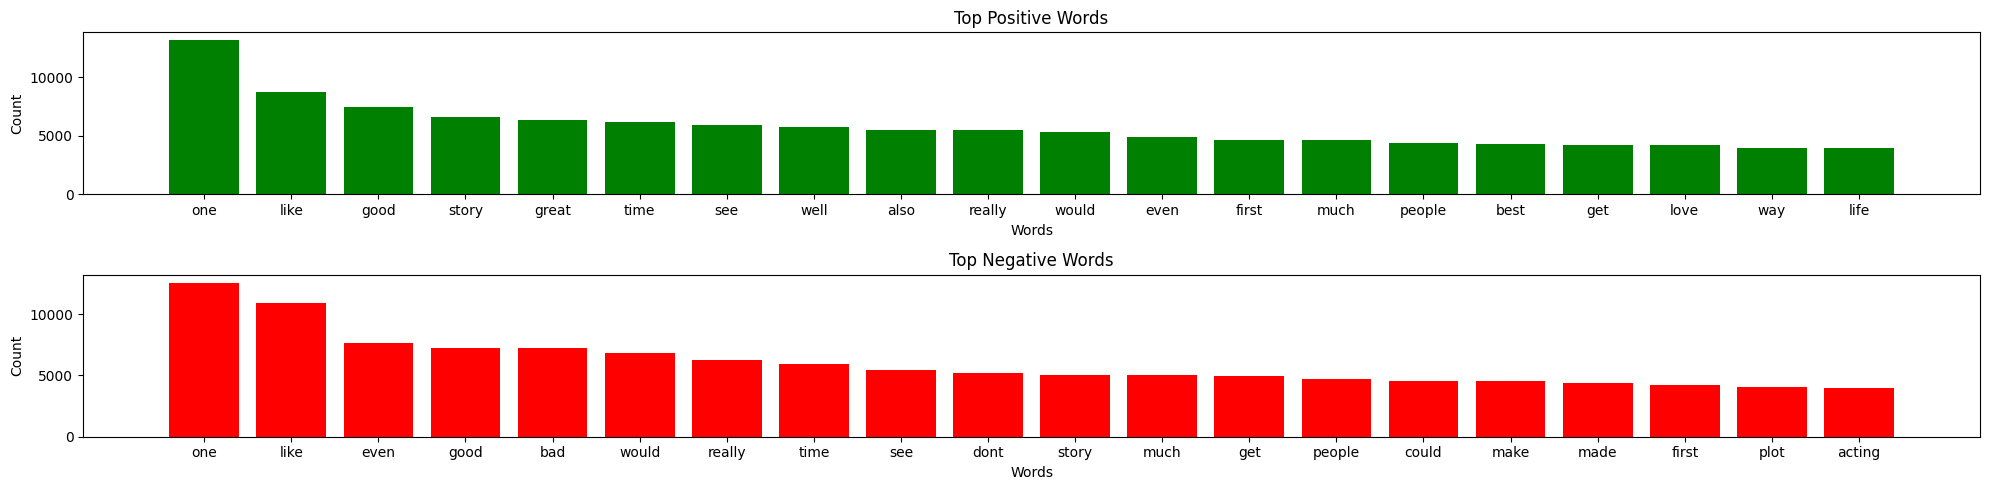

<Figure size 1000x600 with 0 Axes>

In [70]:
#Get top X most common words as dicts
topXPositiveWordsDict = mostCommonPositiveWords[0:count].to_dict()
topXNegativeWordsDict = mostCommonNegativeWords[0:count].to_dict()

#Get the keys to have just the words

topPositiveWords = topXPositiveWordsDict.keys()
topNegativeWords = topXNegativeWordsDict.keys()

#Get the counts to show in graphs

topPositiveWordsCount = topXPositiveWordsDict.values()
topNegativeWordsCount = topXNegativeWordsDict.values()

#Create graphs and subplot
#Adjust fig size to number of words in each graph
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (count,5))

#Plot positive word graph
axes[0].bar(topPositiveWords, topPositiveWordsCount, color='green')
axes[0].set_title('Top Positive Words')
axes[0].set_xlabel('Words')
axes[0].set_ylabel('Count')

#Plot negative word graph
axes[1].bar(topNegativeWords, topNegativeWordsCount, color='red')
axes[1].set_title('Top Negative Words')
axes[1].set_xlabel('Words')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.figure(figsize=(10,6))
plt.show()

Stemming involves reducing words to their root forms to help an algorithm to determine the meaning of words that have the same or similar meaning. e.g. "likes" and "like".

It makes the text more understandable for a machine, but it becomes less understandable to a person, which is why we visualised the word frequency before this step.


In [39]:
from nltk.stem import PorterStemmer

def stemText(input):
  output = []
  stemmer = PorterStemmer()
  for text in input:
    text = [stemmer.stem(word) for word in text]
    output.append(text)
  return pd.Series(output)

stemmedText = stop_word_removed_text.copy(deep=True)
stemmedText['text'] = stemText(stemmedText['text'])
print(stop_word_removed_text['text'][0])
print(stemmedText['text'][0])


del stop_word_removed_text #Clean up as we no longer need the previous dataframe

['rented', 'curiousyellow', 'video', 'store', 'controversy', 'surrounded', 'first', 'released', '', 'also', 'heard', 'first', 'seized', 'us', 'customs', 'ever', 'tried', 'enter', 'country', 'therefore', 'fan', 'considered', 'controversial', 'really', 'see', '', 'plot', 'centered', 'around', 'young', 'swedish', 'drama', 'student', 'named', 'lena', 'wants', 'learn', 'everything', 'life', 'particular', 'wants', 'focus', 'attentions', 'making', 'sort', 'documentary', 'average', 'swede', 'thought', 'certain', 'political', 'issues', 'vietnam', 'war', 'race', 'issues', 'united', 'states', 'asking', 'politicians', 'ordinary', 'denizens', 'stockholm', 'opinions', 'politics', 'sex', 'drama', 'teacher', 'classmates', 'married', 'men', '', 'kills', 'curiousyellow', '', 'years', 'ago', 'considered', 'pornographic', 'really', 'sex', 'nudity', 'scenes', 'far', 'even', 'shot', 'like', 'cheaply', 'made', 'porno', 'countrymen', 'mind', 'find', 'shocking', 'reality', 'sex', 'nudity', 'major', 'staple', '

# Section 2: Representation Learning using TF-IDF and Word2Vec

Representation learning involves converting text into a representation suitable for input for an algorithm (typically numerical vectors). Here our pipeline splits, with different representation methods used for our input for RNN and SVM.

For RNN, we represent our data as vectors using Word2Vec. This involves training a Word2Vec model on the preprocessed reviews to learn word embeddings. We then create an embedding matrix to map words to their embeddings. We then convert our input into an index list, and keep track of this, as well as our embedding matrix and vocabulary size.

For SVM, we using downsampling to avoid excessive resource and time usage, with input values reduced to 10000.

When vectorizing our downsampled data with TF-IDF, we set our number of features to 10000, allowing the algorithm to maintain a satisfactory understanding of word frequency, without overloading RAM or time resources.


In [41]:
import tensorflow_hub as hub
import gensim
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np

x_data = stemmedText['text'].tolist()
y = np.array(stemmedText['label'])

#Data for SVM should be downsampled as it is currently too big (would take too long to train) and not all required
df_for_svm = stemmedText.copy(deep=True)

#Downsize df for SVM and keep an even split
new_df_size = 10000
#Even split between pos/neg when downsized, to prevent bias.
positive_size = new_df_size // 2
negative_size = new_df_size - positive_size
positive_reviews = df_for_svm[df_for_svm['label'] == 1]
negative_reviews = df_for_svm[df_for_svm['label'] == 0]

positive_sample = positive_reviews.sample(n=positive_size, random_state=42)
negative_sample = negative_reviews.sample(n=negative_size, random_state=42)

df_for_svm_downsized = pd.concat([positive_sample, negative_sample]).sample(frac=1, random_state=42)

def convertToRepresentation_tfidf(input):
  vectorizer = TfidfVectorizer(max_features=10000, use_idf=True)
  stringReviews = []
  for review in input:
    stringReview = ' '.join(review)
    stringReviews.append(stringReview)
  # print(stringReviews)
  x_tfidf = vectorizer.fit_transform(stringReviews)
  return x_tfidf.toarray()


def convertToRepresentation_word2vec(input):
  #Train a word2vec model on the reviews
  model=Word2Vec(sentences=input, vector_size=100, window=5, min_count=1, workers=4)
  model.save("word2vec.model")

  #Prepare representations for model
  vocab_size = len(model.wv)
  embedding_dim = 100 #Same as vector size

  #Map the words to their indexes
  word_index = {word: idx for idx, word in enumerate(model.wv.index_to_key)}

  embedding_matrix = np.zeros((vocab_size, embedding_dim))
  for word, idx in word_index.items():
    if word in model.wv:
      embedding_matrix[idx] = model.wv[word]

  x_data_indices = [[word_index.get(word, 0) for word in review] for review in input]
  return [x_data_indices, embedding_matrix, vocab_size]

representationData_w2v = convertToRepresentation_word2vec(x_data)
x_data_represented_w2v = representationData_w2v[0]
embedding_matrix_w2v = representationData_w2v[1]
vocabSize_w2v = representationData_w2v[2]


representationData_tfidf = convertToRepresentation_tfidf(df_for_svm_downsized['text'])
y_data_downsized = df_for_svm_downsized['label']


# Section 3: Algorithms

The first algorithm we will implement is a Recurrent Neural Network. The below code first pads the input data to the size of 100, as each review is required to have the same number of parameters before being used to train the RNN.


In [42]:
import tensorflow
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
#Extra preprocessing - since the same number of parameters should be given for each review, they must be limited/padded to the same size
max_length = 100
x_padded = pad_sequences(x_data_represented_w2v, maxlen = max_length, padding='post', truncating='post')

In the code below we initialise the RNN model. Using the vocabulary and dimension sizes as established earlier, we create a Sequential model (a type of RNN model), with multiple layers, broken down as below:

*   The embedding layer, where the vectorised input is mapped to an appropriate form for the following layers to process
*   The first LSTM (Long Short-Term Memory) layer, used to capture patterns on the embedded output
*   A dropout layer of 20%, found to be effective to reduce overfitting by removing 20% of the previous layer's output before continuing with training
*  The second LSTM layer, used to capture more refined patterns from output of the previous layer.
*   The first Dense layer, used to learn higher level representations of the LSTM output. It uses the ReLU activation to make sure output lies between 0 and 1.
*   Another Dropout layer is again used to reduce overfitting.
*   The final Dense layer is used, with the sigmoid activation, in order to output a value for binary classification. From here, values closer to 0 can be determined to be negative sentiment, and closer to 1 can be determined to be positive.

The model is then compiled using the following:
*   Binary Crossentropy, used to measure the difference between the predicted probabilities and the actual labels.
*   The adam optimizer, an adaptive optimization algorithm that adjusts learning rates dynamically during training. This also uses a clipnorm of 1.0 to help reduce exploding gradients.
*   The accuracy metric, to track correct predictions during training and evaluation.


In [72]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, LeakyReLU
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.initializers import HeUniform, Constant

#Define the model

vocab_size = vocabSize_w2v #Match vocab size from word2vec
embedding_dim = 100 #Match dimension size from word2vec
model = Sequential()

model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length, embeddings_initializer=Constant(embedding_matrix_w2v), trainable=True))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))  # Add dropout regularization

model.add(LSTM(32))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))  # Add dropout regularization

model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001, clipnorm=1.0), metrics=['accuracy'])



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

The below code splits the preprocessed and padded input into training and testing sets. The RNN model is then trained on the training data and evaluated on the testing data.





In [73]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

#Split into test and training data
x_train, x_test, y_train, y_test = train_test_split(x_padded, y, test_size=0.2, random_state=42)

#Train the RNN - 10 epochs was enough for the model to reach satisfactory accuracy without excessive resource and time usage.
myRNN = model.fit(x_train, y_train,
                  validation_split=0.2,
                  epochs=10,
                  batch_size=32)

#Evaluate the effectiveness of the training

rnn_loss, rnn_accuracy = model.evaluate(x_test, y_test)


#Calculate scoring metrics
#Performance is measured using Precision, Accuracy, F1 and Recall.
predictions = (model.predict(x_test) > 0.5).astype("int32") #A threshold of 0.5 is established to differentiate between positive and negative reviews
rnn_precision = precision_score(y_test, predictions)
rnn_recall = recall_score(y_test, predictions)
rnn_f1score = f1_score(y_test, predictions)
print(f"Precision: {rnn_precision}")
print(f"Recall: {rnn_recall}")
print(f"F1 Score: {rnn_f1score}")
print(f"Test accuracy: {rnn_accuracy *100:.2f}%")

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.5216 - loss: 0.6923 - val_accuracy: 0.5828 - val_loss: 0.6568
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6954 - loss: 0.6000 - val_accuracy: 0.7157 - val_loss: 0.6046
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.7530 - loss: 0.5443 - val_accuracy: 0.7878 - val_loss: 0.4869
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.7950 - loss: 0.4804 - val_accuracy: 0.7943 - val_loss: 0.4564
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8136 - loss: 0.4450 - val_accuracy: 0.7922 - val_loss: 0.4615
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8197 - loss: 0.4222 - val_accuracy: 0.8213 - val_loss: 0.4293
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8421 - loss: 0.3917 - val_accuracy: 0.8217 - val_loss: 0.4193
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8544 - loss: 0.3782 - val_acc

Next is SVM (Support Vector Machine). In the below code we scale our TF-IDF represented data, before separating into training and testing data.

We then create a LinearSVC model with a regularization parameter of 0.01 (found optimal during parameter tuning - next segment). Maximum iterations of 1000 is enough to achieve suitable results without compromising RAM usage or time constraints, and setting the class weight to 'balanced' to handle potential class imbalances.



In [45]:
import time
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

scaler = StandardScaler(with_mean=False)  # Use with_mean=False for sparse data like TF-IDF

x_train_svm, x_test_svm, y_train_svm, y_test_svm = train_test_split(
    representationData_tfidf, y_data_downsized, test_size=0.2, random_state=42
)

#Convert data to numpy arrays
x_train_svm = np.asarray(x_train_svm, dtype='float')
y_train_svm = np.asarray(y_train_svm, dtype='float')

#Scale testing and training
x_train_svm_scaled = scaler.fit_transform(x_train_svm)
x_test_svm_scaled = scaler.fit_transform(x_test_svm)

#Train the SVM
classifier_linear = LinearSVC(C=0.01, max_iter=1000, class_weight='balanced')
classifier_linear.fit(x_train_svm_scaled, y_train_svm)

#Once trained, the SVM model is then tested on the test data created from the earlier split.
#From here, the metrics such as Precision, Recall and f1 can be obtained.
prediction_linear = classifier_linear.predict(x_test_svm)

report = classification_report(y_test_svm, prediction_linear, output_dict=True)
positiveScores = report['1']
negativeScores = report['0']

svm_positive_precision = positiveScores['precision']
svm_negative_precision = negativeScores['precision']

svm_positive_recall = positiveScores['recall']
svm_negative_recall = negativeScores['recall']

svm_positive_f1 = positiveScores['f1-score']
svm_negative_f1 = negativeScores['f1-score']

print(f"\nPositive Review Detection: \nPrecision: {svm_positive_precision} \nRecall: {svm_positive_recall} \nF1 Score: {svm_positive_f1}")
print(f"\nNegative Review Detection: \nPrecision: {svm_negative_precision} \nRecall: {svm_negative_recall} \nF1 Score: {svm_negative_f1}")


Positive Review Detection: 
Precision: 0.8730650154798761 
Recall: 0.8351431391905232 
F1 Score: 0.8536831483350151

Negative Review Detection: 
Precision: 0.8380213385063046 
Recall: 0.8753799392097265 
F1 Score: 0.8562933597621407


In [46]:
#Hyperparameter tuning of SVC

from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

param_grid = {'C': [0.01, 0.1, 1, 10]}
grid_search = GridSearchCV(LinearSVC(class_weight='balanced', max_iter=1000), param_grid, cv=3, scoring='f1_weighted')
grid_search.fit(x_train_svm_scaled, y_train_svm)

print(f"Best Parameters: {grid_search.best_params_}")
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test_svm_scaled)
print(classification_report(y_test_svm, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best Parameters: {'C': 0.01}
              precision    recall  f1-score   support

           0       0.82      0.83      0.83       987
           1       0.83      0.82      0.83      1013

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000



# Section 4: Evaluation

SVM precision: 0.8555431769930903
RNN precision: 0.8427876823338736
SVM recall: 0.8552615392001248
RNN recall: 0.8370221327967807
SVM f1: 0.8549882540485779
RNN f1: 0.8398950131233596


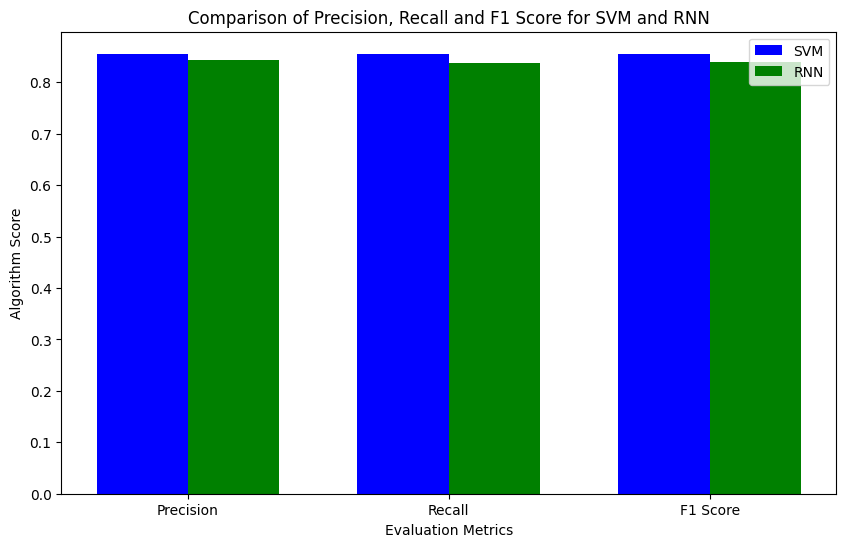

In [74]:
#Bar plot to evaluate Precision, Recall and f1 score
import matplotlib.pyplot as plt
metrics = ["Precision", "Recall", "F1 Score"]
models = ["SVM", "RNN"]
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.35
ind = np.arange(len(metrics))

svm_precision = np.mean([svm_positive_precision, svm_negative_precision])
svm_recall = np.mean([svm_positive_recall, svm_negative_recall])
svm_f1 = np.mean([svm_positive_f1, svm_negative_f1])

print(f"SVM precision: {svm_precision}")
print(f"RNN precision: {rnn_precision}")
print(f"SVM recall: {svm_recall}")
print(f"RNN recall: {rnn_recall}")
print(f"SVM f1: {svm_f1}")
print(f"RNN f1: {rnn_f1score}")


bar_svm = ax.bar(ind - width/2, [svm_precision, svm_recall, svm_f1], width, label="SVM", color="b")
bar_rnn = ax.bar(ind + width/2, [rnn_precision, rnn_recall, rnn_f1score], width, label="RNN", color="g")

ax.set_xlabel("Evaluation Metrics")
ax.set_ylabel("Algorithm Score")
ax.set_title("Comparison of Precision, Recall and F1 Score for SVM and RNN")
ax.set_xticks(ind)
ax.set_xticklabels(metrics)
ax.legend()

plt.show()

The above plot shows that both algorithms perform very successfully at identifying positive and negative reviews, and for each metric, score very similarly

*   Since the precision score is slightly higher for SVM than for RNN, this implementation of SVM is marginally better at minimizing false positives, and at identifying true positives correctly.
*   With SVM also obtaining a higher Recall score, this means that SVM outperforms RNN at identifying actual positive instances, making it better at minmizing false negatives.
*   Again, with SVM obtaining a very slightly higher f1 score than RNN, it is slightly more superior at keeping a balance between precision and recall.

Although SVM consistently outperforms RNN, it is only very slightly, and both algorithms still perform effectively.



# Section 5: Paper Overview: Universal Language Model Fine-tuning for Text Classification




This paper explores Universal Language Model Fine-tuning (ULMFiT), a transfer learning method for natural language processing. ULMFiT leverages a pretrained language model and applies multiple fine-tuning techniques to adapt it to various tasks, achieving state-of-the-art performance on sentiment analysis of IMDB movie reviews (the focus here).
ULMFiT's Sentiment analysis consists of the following main steps:




1.   General-domain LM Pretraining: A language model is pretrained on a large dataset to learn general language patterns.

2.   Target task LM fine-tuning: The pretrained model's encoder is finetuned for the specific task at hand, such as sentiment analysis. Techniques include:


*   Discriminative fine-tuning: Different layers are fine tuned using different learning rates. Lower layers are fine tuned with smaller learning rates, while higher layers, which are more task specific, are given larger learning rates.
*   Slanted Triangular Learning Rates: Learning rates are increased initially, and then decreased, stabilizing training and reducing overfitting.


3.   Target task classifier fine-tuning: the model is augmented using batch normalization, dropout and advanced methods like:


*   Concat pooling: Combining max pooling, average pooling, and the last hidden state for classification.
*   Gradual unfreezing: Incrementally unfreezing layers to ensure stable finetuning, avoiding catastrophic forgetting
*   BPTT: Training the model on large input sequences using backpropagation through time.
*   Bidirectional LM: Utilizing both forward and backward language models.




# Section 6: Algorithms

In [ ]:
#fastai is required for the below code
!pip install fastai

In [48]:
#Separate our data again from the orginal dataframe at the start into test and training for ULMFiT
import pandas as pd
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)
#Rename columns to fit the paper
train_df = train_df.rename(columns={'text': 'review', 'label': 'sentiment'})
valid_df = valid_df.rename(columns={'text': 'review', 'label': 'sentiment'})
#Separate training and validation but join into one df
train_df['is_valid'] = False
valid_df['is_valid'] = True
combined_df = pd.concat([train_df, valid_df], ignore_index=True)

In [49]:
#The below code sets up a AWD LSTM language model to be trained on the imdb datset.
#Please note:
#I've found the below code to only successfully run when I switched to the A100 GPU runtime on google colab.
#It might work when run using others, but A100 was the only one I found to consistently work. When simply run on a CPU it would give Argument errors when finetuning.
#Please note this if you get argument errors when running the below code!
#Matching all parameters to the implementation from the code document would be very difficult without causing errors, due to the lack of documentation from fastai, surrounding custom parameters for aspects such as AWD LSTM.
#However I was able to find documentation on how to provide dropout rates for the different layers of the LM, and this has been implemented as in the paper.
#In addition, the below recreation makes sure to use the same methodology and steps as mentioned above, in the breakdown of the use of ULMFiT in sentiment analysis.


#Implementation aided with https://docs.fast.ai/text.learner.html#language_model_learner
#And https://docs.fast.ai/text.models.awdlstm.html
from fastai.text.all import *

from fastai.text.models.awdlstm import awd_lstm_lm_config

myAWD_LSTM = awd_lstm_lm_config.copy()
#Matching all parameters to the implementation from the code document would be very difficult, due to the lack of documentation from fastai, surrounding custom parameters for aspects such as AWD LSTM

#The below parameters from paper were unable to be recreated without causing errors
#Embedding size of 400
# myAWD_LSTM['emb_sz'] = 400
# #3 Layers
# myAWD_LSTM['n_layers'] = 3
# #1150 hidden activations per layer - not possible as this causes a mismatch with torch
# myAWD_LSTM['n_hid'] = 1150

#Establish dropout rate parameters as in paper:
myAWD_LSTM['hidden_p'] = 0.3 # Dropout probability for hidden state between layers: 0.3
myAWD_LSTM['input_p'] = 0.4 # Dropout probability for LSTM stack input: 0.4
myAWD_LSTM['embed_p'] = 0.05 # Embedding layer dropout probability: 0.05
myAWD_LSTM['weight_p'] = 0.5 # Hidden-to-hidden weight dropout probability for LSTM layers: 0.5

#Load dataset into a dataloader object - using a batch size of 64 as mentioned in parameters in paper
dls_lm = TextDataLoaders.from_df(combined_df, text_col="review", is_lm=True, valid_col='is_valid', bs=64)

#Create a langauge model learner
learn_lm = language_model_learner(dls_lm, AWD_LSTM, config=myAWD_LSTM, metrics = [accuracy, Perplexity()])

##LANGUAGE MODEL FINE TUNING
#A learning rate of 0.01 is set, which will change between layers as expected due to slanted triangular Learning Rates.
learn_lm.fine_tune(5, base_lr=1e-2) #STLR used automatically here, epochs set to 5 for this recreation, as any more than this does not massively increase accuracy at this stage.
#Save pretrained model
learn_lm.save_encoder('finetuned_lm_encoder')

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


/usr/local/lib/python3.10/dist-packages/fastai/text/learner.py:149: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  wgts = torch.load(wgts_fname, map_location = lambda storage

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.888649,4.266340,0.265035,71.260330,03:10


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.519608,4.113397,0.278290,61.154083,03:17
1,4.365025,4.043008,0.284505,56.997524,03:17
2,4.273993,3.981301,0.290524,53.586697,03:15
3,4.210305,3.937044,0.295278,51.266838,03:17
4,4.135979,3.928643,0.296331,50.837917,03:15


Target Task Classifier Fine Tuning

In [50]:
#Implementation aided with https://docs.fast.ai/text.learner.html#text_classifier_learner
#And https://docs.fast.ai/text.models.core.html
#Load config
from fastai.text.models.awdlstm import awd_lstm_clas_config

#Create custom config
myAWD_LSTM_CLAS = awd_lstm_clas_config.copy()
#Classifier uses a hidden layer parameter of 50 in paper - not possible as this causes a mismatch with torch
# myAWD_LSTM_CLAS['n_hid'] = 50

#Load imdb dataset for text classification, this uses BPTT inherently
print("Loading the dataset using BPTT...")
dls_clas = TextDataLoaders.from_df(combined_df, text_col="review", label_col="sentiment", text_vocab=dls_lm.vocab)

#Create custom adam optimizer as mentioned in the paper: β1 = 0.7 instead of the default β1 = 0.9 and β2 = 0.99
def custom_adam(params, **kwargs):
    return Adam(params, mom=0.7, sqr_mom=0.99, **kwargs)

#Create the classifier learner using concat pooling automatically
print("Creating classifier learner using concat pooling...")
learn_clas = text_classifier_learner(dls_clas, AWD_LSTM, config=myAWD_LSTM_CLAS, metrics=[accuracy, Precision(), Recall(), F1Score()], opt_func=custom_adam)
print(learn_clas.model)

#Load the pretrained langauge model encoder
learn_clas.load_encoder('finetuned_lm_encoder')

#Fine tune the classifier
print("Fine tuning the classifier...")
learn_clas.fine_tune(4, base_lr=1e-2) #STLR used automatically here, as well as gradual unfreezing. 4 Epochs is enough to reach suitable accuracy without taking too long
learn_clas.save('finetuned_lm_clas')


Loading the dataset using BPTT...


/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


Creating classifier learner using concat pooling...


/usr/local/lib/python3.10/dist-packages/fastai/text/learner.py:149: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  wgts = torch.load(wgts_fname, map_location = lambda storage

SequentialRNN(
  (0): SentenceEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(38392, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(38392, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0-2): 3 x RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): LinBnDrop(
        (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Dropout(p=0.2, inplace=False)
        (2): Linear(in_features=1200, out_features=50, bias=False)
        (3): ReLU(inplace=True)
      )
      (1): LinBnDrop(
        (0): B

/usr/local/lib/python3.10/dist-packages/fastai/text/learner.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  wgts = torch.load(join_path_file(file,self.path/self.model_

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.352058,0.314217,0.864400,0.847727,0.890215,0.868452,00:23


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.257036,0.296543,0.880400,0.965049,0.790772,0.869261,00:37
1,0.209483,0.220700,0.905800,0.867314,0.959427,0.911048,00:37
2,0.140488,0.186409,0.926600,0.923471,0.931185,0.927312,00:37
3,0.087616,0.202851,0.924000,0.912606,0.938743,0.925490,00:37


Path('models/finetuned_lm_clas.pth')

In [51]:
#Validate on the test set and gather metrics
valid_results = learn_clas.validate()

# If you need additional metrics
from sklearn.metrics import classification_report

preds, truths = learn_clas.get_preds()
pred_labels = preds.argmax(dim=1)
print(classification_report(truths, pred_labels))

report = classification_report(truths, pred_labels, output_dict=True)
positiveScores = report['1']
negativeScores = report['0']

ulmfit_positive_precision = positiveScores['precision']
ulmfit_negative_precision = negativeScores['precision']
ulmfit_precision = np.mean([ulmfit_positive_precision, ulmfit_negative_precision])

ulmfit_positive_recall = positiveScores['recall']
ulmfit_negative_recall = negativeScores['recall']
ulmfit_recall = np.mean([ulmfit_positive_recall, ulmfit_negative_recall])

ulmfit_positive_f1 = positiveScores['f1-score']
ulmfit_negative_f1 = negativeScores['f1-score']
ulmfit_f1 = np.mean([ulmfit_positive_f1, ulmfit_negative_f1])

ulmfit_accuracy = report['accuracy']

              precision    recall  f1-score   support

           0       0.94      0.91      0.92      2486
           1       0.91      0.94      0.93      2514

    accuracy                           0.92      5000
   macro avg       0.92      0.92      0.92      5000
weighted avg       0.92      0.92      0.92      5000



# Section 7: Evaluation

SVM precision: 0.8555431769930903
RNN precision: 0.8427876823338736
ULMFiT precision: 0.8427876823338736
SVM recall: 0.8552615392001248
RNN recall: 0.8370221327967807
ULMFiT recall: 0.8370221327967807
SVM f1: 0.8549882540485779
RNN f1: 0.8398950131233596
ULMFiT f1: 0.8398950131233596


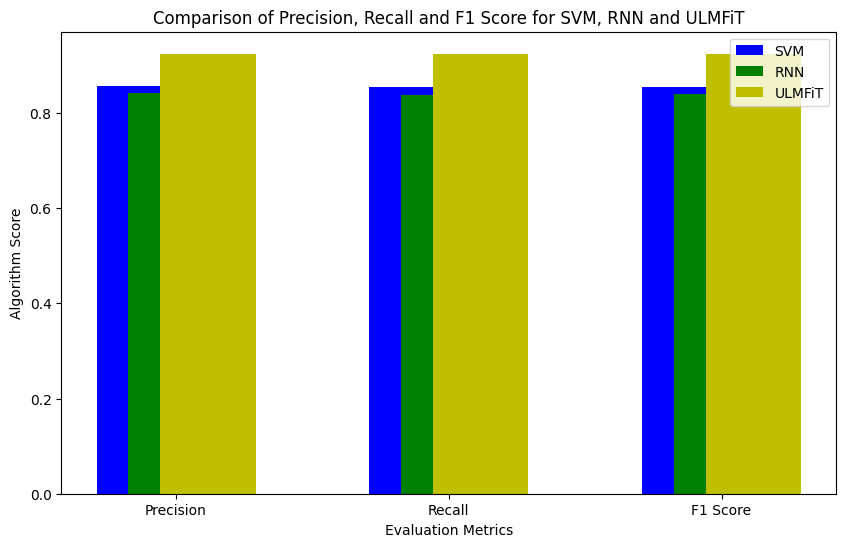

In [75]:
#Bar plot to evaluate Precision, Recall and f1 score of all algorithms
import matplotlib.pyplot as plt
metrics = ["Precision", "Recall", "F1 Score"]
models = ["SVM", "RNN", "ULMFiT"]
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.35
ind = np.arange(len(metrics))

# svm_precision = np.mean([svm_positive_precision, svm_negative_precision])
# svm_recall = np.mean([svm_positive_recall, svm_negative_recall])
# svm_f1 = np.mean([svm_positive_f1, svm_negative_f1])

print(f"SVM precision: {svm_precision}")
print(f"RNN precision: {rnn_precision}")
print(f"ULMFiT precision: {rnn_precision}")

print(f"SVM recall: {svm_recall}")
print(f"RNN recall: {rnn_recall}")
print(f"ULMFiT recall: {rnn_recall}")

print(f"SVM f1: {svm_f1}")
print(f"RNN f1: {rnn_f1score}")
print(f"ULMFiT f1: {rnn_f1score}")



bar_svm = ax.bar(ind - width/3, [svm_precision, svm_recall, svm_f1], width, label="SVM", color="b")
bar_rnn = ax.bar(ind, [rnn_precision, rnn_recall, rnn_f1score], width, label="RNN", color="g")
bar_ulmfit = ax.bar(ind + width/3, [ulmfit_precision, ulmfit_recall, ulmfit_f1], width, label="ULMFiT", color="y")
ax.set_xlabel("Evaluation Metrics")
ax.set_ylabel("Algorithm Score")
ax.set_title("Comparison of Precision, Recall and F1 Score for SVM, RNN and ULMFiT")
ax.set_xticks(ind)
ax.set_xticklabels(metrics)
ax.legend()

plt.show()

Although only trained using the IMDB dataset, the implementation recreated from the paper, is massively successful at identifying the sentiment of IMDB reviews, outperforming both the SVM and RNN implemented previously in this experiment. It is likely that with more parameters that would match the paper, an even higher measure of accuracy could be achieved, however the discrepency between the two is not huge.

Below shows the discrepency between error rates from the ULMFiT paper recreation and original implementation. Error rates are marginally higher for the recreation, but not by a massive amount, showing that the recreation is almost as effective at identifying sentiment of IMDB reviews.

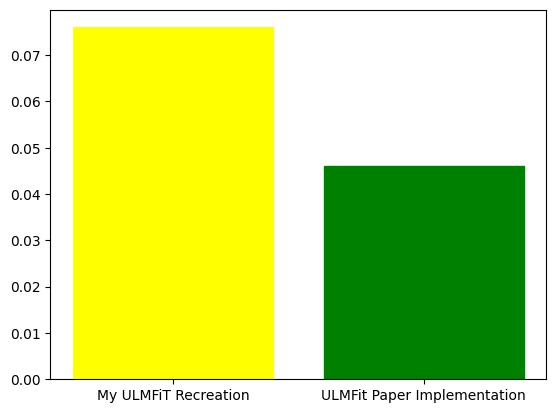

In [76]:
import matplotlib.pyplot as plt
import numpy as np
models = ["My ULMFiT Recreation", "ULMFit Paper Implementation"]
#Establish error rate as in paper
ulmfit_error_paper = 4.6 / 100
my_ulmFit_error = 1 - ulmfit_accuracy
values = [my_ulmFit_error, ulmfit_error_paper]

barPlot = plt.bar(models, values)
barPlot[0].set_color('yellow')
barPlot[1].set_color('green')
